# LLM Abliterate v1.2 script, adapted for google/abliterate-gemma-2-27b-it (uses bartowski's gguf for llama.cpp)

Author: byroneverson

This script ran at kaggle.com, accelerator: None, persistence: Files only

# Download bartowski/gemma-2-27b-it-GGUF gemma-2-27b-it-Q4_K_M.gguf locally

Using the largest quant that will fit in /kaggle/working directory. (19.5GiB max and we also need a couple gigs of wiggle room)

In [ ]:
%cd /kaggle/working

from huggingface_hub import hf_hub_download

hf_hub_download(repo_id="bartowski/aya-expanse-8b-GGUF", filename="aya-expanse-8b-Q4_K_M.gguf", local_dir="/kaggle/working")

# Download original abliterator script for harmful and harmless instructions txt files
Credit: https://github.com/Sumandora/remove-refusals-with-transformers

Temporary: We need my fork of ggml-python because the official abetlen is out of date and ggml_tensor is incompatible at the moment.

In [ ]:
%cd /kaggle/working
!git clone https://github.com/Sumandora/remove-refusals-with-transformers.git
!git clone --recurse-submodules https://github.com/byroneverson/ggml-python.git

# Install my ggml-python, llama-cpp-python, and couple other reqs

In [ ]:
%cd /kaggle/working

!pip install ./ggml-python
!pip install llama-cpp-python
!pip install jaxtyping
!pip install einops

# Obtain layer output embeddings for each of our sample instruction sets (harmful and harmless)

- These will be saved to the folders "harmful_states" and "harmless_states".
- Each output file contains a tensor of shape (n_layes, n_embd). E.g. (46, 4608) for this model.
- A quant (q4_k_m) model is used for this process with llama.cpp for minimal cpu and memory usage.
- Considering we will end up using the mean of these samples, the amount of quantization shouldn't matter much.

In [ ]:
%cd /kaggle/working

import ctypes
import os
import multiprocessing
import random
import gc
import sys
import re

# llama.cpp/GGML library
import llama_cpp
import ggml

# Easy tensor handling
import torch
from math import prod

from tqdm import tqdm

# Number of total layers in your model
total_layers = 32
target_percent = 0.5 # 50% through the layers
target_index = int(total_layers * target_percent)
# Middle 8 layers to keep for PCA
target_count = 32 #8
target_start = target_index - (target_count // 2)
target_end = target_index + (target_count // 2)

# Number of instructions to average for our feature estimation (e.g. 512 for harmful and 512 for harmless)
instructions = 128 #32 #512

# Our local gguf model
# TODO: Load model with only num_layers we actually need for this step
local_repo_dir = "/kaggle/working"
model_path = local_repo_dir + "/" + "aya-expanse-8b-Q4_K_M.gguf"

# Init llama backend
llama_cpp.llama_backend_init(numa=False)

# llama.cpp custom model code

def c_array_to_tensor(pointer, shape, torch_type):
    arr = (pointer._type_ * prod(shape)).from_address(
    ctypes.addressof(pointer.contents))
    return torch.frombuffer(arr, dtype=torch_type).view(*shape)

def model_load(model_path):
    # TODO: Attempt to hook num_layers
    model_params = llama_cpp.llama_model_default_params()
    model_params.n_gpu_layers = 0
    model_params.use_mmap = True
    model = llama_cpp.llama_load_model_from_file(model_path.encode("utf-8"), model_params)
    
    return model

def model_free(model):
    llama_cpp.llama_free(model)

def model_apply_chat_template(model, role, content, add_assistant=True):
    chat_message = llama_cpp.llama_chat_message(role=role.encode("utf-8"), content=content.encode("utf-8"))
    buffer_length = len(content) * 2
    buffer = ctypes.create_string_buffer(buffer_length)
    result = llama_cpp.llama_chat_apply_template(model, None, ctypes.pointer(chat_message), 1, add_assistant, buffer, ctypes.c_int32(buffer_length))
    if result <= 0:
        return input_str
    elif result >= buffer_length:
        buffer_length = result + 1
        buffer = ctypes.create_string_buffer(buffer_length)
        result = llama_cpp.llama_chat_apply_template(model, None, ctypes.pointer(chat_message), 1, add_assistant, buffer, ctypes.c_int32(buffer_length))
    if result > 0:
        return buffer.value.decode("utf-8")
    else:
        return content
    
def model_tokenize(model, prompt):
    prompt_count = len(prompt.encode('utf-8'))
    if prompt_count == 0:
        return []

    tokens = (ctypes.c_int32 * prompt_count)()
    count = llama_cpp.llama_tokenize(model, 
                                     prompt.encode('utf-8'), 
                                     ctypes.c_int32(prompt_count), 
                                     tokens, 
                                     ctypes.c_int32(prompt_count), 
                                     True, 
                                     True)
    if prompt_count > count:
        tokens = tokens[:count]
    return tokens

def print_tensor_info(t_ptr):
     #: contiguous: {ggml.ggml_is_contiguous(t)}, permuted: {ggml.ggml_is_permuted(t)}, transposed: {ggml.ggml_is_transposed(t)}"
    t = t_ptr.contents
    print(f"{ggml.ggml_type_name(t.type)} {ggml.ggml_op_desc(t_ptr)} {t.name}")
    print(f"  n_elements = {ggml.ggml_nelements(t)}")
    print(f"  ne         = ({t.ne[0]}, {t.ne[1]}, {t.ne[2]}, {t.ne[3]})")
    print(f"  nb         = ({t.nb[0]}, {t.nb[1]}, {t.nb[2]}, {t.nb[3]})")
    is_host = ggml.ggml_backend_buffer_is_host(t.buffer)
    print(f"  is_host    = {is_host}")
    print(f"  buffer     = {t.buffer}")
    print(f"  data       = {t.data}")
    if ctypes.c_void_p.from_buffer(t.src[0]).value != None:
        print(f"  src[0]     = {ggml.ggml_op_desc(t.src[0])}")
    if ctypes.c_void_p.from_buffer(t.src[1]).value != None:
        print(f"  src[1]     = {ggml.ggml_op_desc(t.src[1])}")

def is_l_out(string):
    match = re.match(r"l_out-(\d+)", string)
    if match:
        return int(match.group(1))
    else:
        return -1

# Callback will fill this during model inference
class CallbackDataStruct(ctypes.Structure):
    _fields_ = [
        ("layer", ctypes.c_int),
        ("buffer", ctypes.POINTER(ctypes.c_float))
    ]

callback_data = CallbackDataStruct()
callback_data.layer = 0

def hidden_states_eval_callback(t_void_p, ask, user_data):
    cb_data_ptr = ctypes.cast(user_data, ctypes.POINTER(CallbackDataStruct))
    cb_data = cb_data_ptr.contents
    t_ptr = ctypes.cast(t_void_p, ctypes.POINTER(ggml.ggml_tensor))
    t = t_ptr.contents
    if ask:
        l_out_i = is_l_out(t.name.decode('utf-8'))
        if target_start <= l_out_i < target_end:
            # Request data next callback
            #print(t.name)
            #sys.stdout.flush()
            #print(f"Target layer {layer_index}, tensor {index}")
            return True
    else:
        layer = cb_data.layer
        cb_data.layer += 1
        data = ctypes.cast(t_ptr.contents.data, ctypes.POINTER(ctypes.c_float))
        # TODO: Use ctypes.memmove
        for i in range(t.ne[0]):
            buffer[layer * t.ne[0] + i] = data[t.ne[0] * (t.ne[1]-1) + i]
        # Returning false stops graph in it's tracks without error
        return not (cb_data.layer >= target_count)
    # return True to request data next callback, false to skip, ask will be False when returning data from a request
    return False

c_hidden_states_eval_callback = ctypes.CFUNCTYPE(
    ctypes.c_bool, ctypes.c_void_p, ctypes.c_bool, ctypes.c_void_p
)(hidden_states_eval_callback)  

def model_generate_hidden_states(model, prompt, buffer):
    # Set callback vars
    #callback_data.n_embd = llama_cpp.llama_n_embd(model)
    callback_data.layer = 0
    callback_data.buffer = buffer
    
    # Chat template
    prompt = model_apply_chat_template(model, 
                                       role="user", 
                                       content=prompt, 
                                       add_assistant=True)
    
    # Add space for llama only, check model params for add space var
    add_space = False # TODO: Check model/config for this, not used for gemma 2
    if add_space:
        prompt = b" " + prompt
    
    toks = model_tokenize(model, prompt)
    n_tokens = len(toks)
    #print(prompt)
    #print(n_tokens)
    #print(toks)

    # Clear cache per sample instruction
    llama_cpp.llama_kv_cache_clear(context)
    
    # Fill batch
    batch.n_tokens = n_tokens
    for i in range(n_tokens):
        batch.token[i] = toks[i]
        batch.pos[i] = i
        batch.seq_id[i][0] = 0
        batch.n_seq_id[i] = 1
        batch.logits[i] = False
    batch.logits[n_tokens - 1] = True
    
    # Decode batch
    result = llama_cpp.llama_decode(context, batch)
    if result == 1:
        print("decode warning")
    elif result < 0:
        print("decode error")
    sys.stdout.flush()
    
    # Convert float buffer to torch array for easy handling
    tensor = c_array_to_tensor(buffer, (target_count, llama_cpp.llama_n_embd(model)), torch.float32)
    #print(tensor)
    return tensor

# Clear memory of past model usage
model = None
gc.collect()

# Load model
model = model_load(model_path)

print("Instruction count: " + str(instructions))

with open("./remove-refusals-with-transformers/harmful.txt", "r") as f:
    harmful = f.readlines()

with open("./remove-refusals-with-transformers/harmless.txt", "r") as f:
    harmless = f.readlines()

harmful_instructions = random.sample(harmful, instructions)
harmless_instructions = random.sample(harmless, instructions)

# Generate target layer hidden state files for harmful and harmless features
def save_target_hidden_states(prompt, index, feature, buffer):
    bar.update(n=1)
    
    # Generates using each example, cache is disables so it doesn't keep previous examples in it's context, obviously we need to output the full states
    # It would be ideal if we could have it output the states for only the layer we want
    output = model_generate_hidden_states(model, prompt, buffer)
    # We still select the target layers, then only keep the hidden state of the last token (-1 part)
    hidden = output #output.hidden_states[0][target_index][:, -1, :]
    # Save each hidden state to disk to keep memory usage at a minimum
    dir_path = local_repo_dir + "/" + feature + "_states"
    file_path = dir_path + "/" + str(index) + ".pt"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    torch.save(hidden, file_path)

# Create context
context_params = llama_cpp.llama_context_default_params()
n_threads = multiprocessing.cpu_count()
context_params.n_threads = n_threads
context_params.n_threads_batch = n_threads
context_params.seed  = 1234
context_params.cb_eval = c_hidden_states_eval_callback
context_params.cb_eval_user_data = ctypes.cast(ctypes.pointer(callback_data), ctypes.c_void_p)
context = llama_cpp.llama_new_context_with_model(model, context_params)

# Create batch
batch = llama_cpp.llama_batch_init(context_params.n_batch, 0, context_params.n_ctx)

# Progress bar
import time
time.sleep(5) # Let model finish printing before start
sys.stdout.flush()
max_its = instructions * 2
bar = tqdm(total=max_its)

# Create ctypes float buffer
buffer = ctypes.cast(ctypes.create_string_buffer(target_count * llama_cpp.llama_n_embd(model) * 4), ctypes.POINTER(ctypes.c_float))

# Save harmful states
for index, instruction in enumerate(harmful_instructions):
    save_target_hidden_states(instruction, index, "harmful", buffer)

# Save harmless states
for index, instruction in enumerate(harmless_instructions):
    save_target_hidden_states(instruction, index, "harmless", buffer)

# End progress bar
bar.close()

# Free batch, model, context, and backend
llama_cpp.llama_batch_free(batch)
llama_cpp.llama_free(context)
llama_cpp.llama_free_model(model)
llama_cpp.llama_backend_free()

# Clean-up
model = None
context = None
harmful_instructions = None
harmless_instructions = None
gc.collect()


# Get refusal direction vector using my PCA (Primary Component Analysis) algorithm and save

My algorithm attempts to find the ideal layer to use for the refusal direction calculation:
1. PCA all layers into 10 components per layer, 1st PC will be used.
2. Sort PCA components to help visualize the process.
3. Calculate a bounding box for sample instructions (excluding outliers) in PCA using z-score based thresholding.
4. Iterate through layers and when the bounding boxes are no longer clashing we can assume that the model has started refusing.
5. This un-clashing of overlap can be tuned using the "coverage" hyper-parameter, which basically determines what an outlier is.
6. We will end up using the layer index of the first case where the boxes no longer clash.

Notes:
- The number of sample instructions used directly influences this algorithm. Obviously more sample = better approximation.
- It is confirming to see that the variance is much lower for the harmful than the harmless at the last layer. This is because most of the harmful responses will be almost the same ("I can't ...") and the harmless responses will vary greatly. So the layer where the variances start to differ is probably where the refusal starts getting serious.
- There will be "potential" contenders that have a gap between the bounding boxes but from my experience with smaller model, using a layer too far after the model has started refusing is not responsible (at least partially) for the refusal and is simply adding to it. This is anecdotal and will need more research.
- This is a new algorithm still in alpha development so it is subject to serious change. I plan to test it with previous known working abliterations I have done to see if it chooses a layer close to the one I had manually set and whether or not it works (for better or worse).

TODO:
- The layer plots would look amazing as an animation that interpolates the scatter point positions motion. They look like stills of a video.
- Use data from 2nd PC as well. E.g. most contribution from 1st PC targetting correct dims from embed, some contr. from 2nd for other dims. Reverse the PCA to find contributions from embed for each component, etc.
- Develop the algorithm further and give it a clever name based on overall method.
- Double check if cosine similarity code is correct. I am not seeing as perfect of a correlation between mean_diff and the top PCs as the methods this work was based on.

Based on methods described here: https://www.lesswrong.com/posts/jGuXSZgv6qfdhMCuJ/refusal-in-llms-is-mediated-by-a-single-directionhttps://www.lesswrong.com/posts/jGuXSZgv6qfdhMCuJ/refusal-in-llms-is-mediated-by-a-single-direction

/kaggle/working
Using z-score threshold: 1.1503493785858154


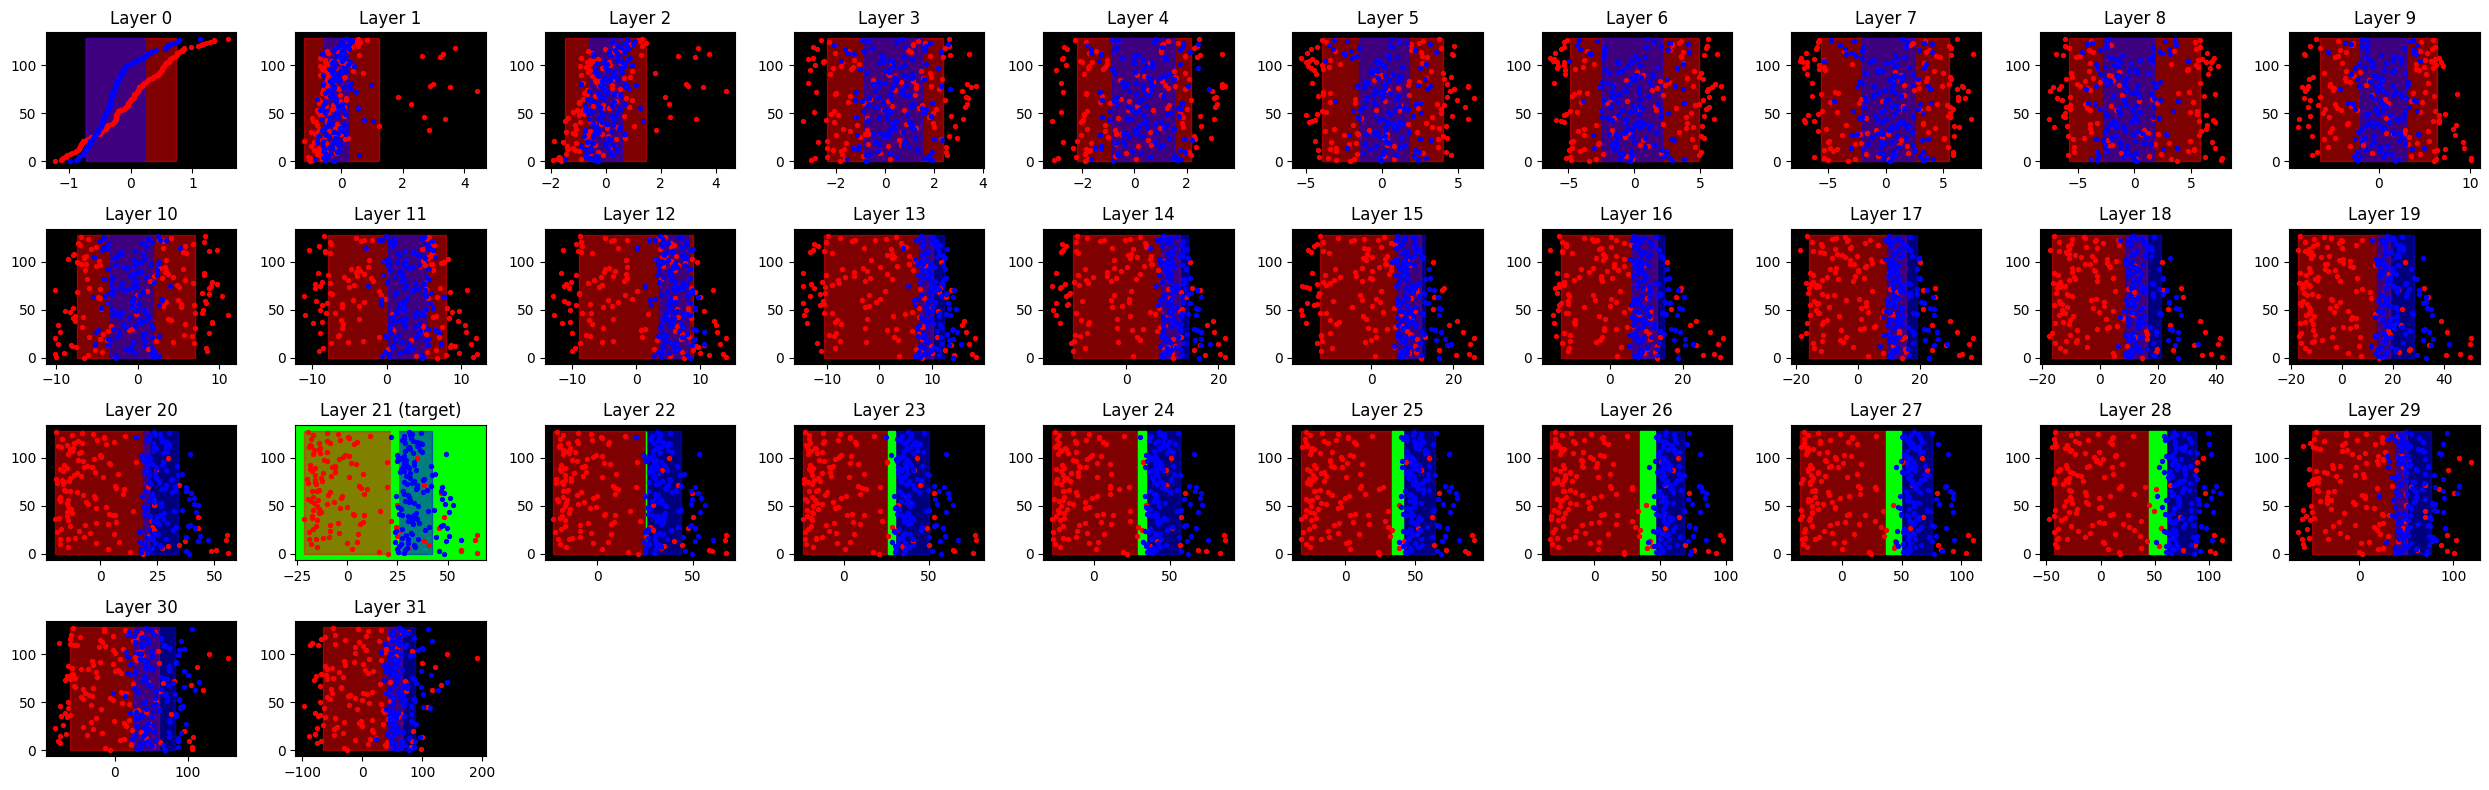

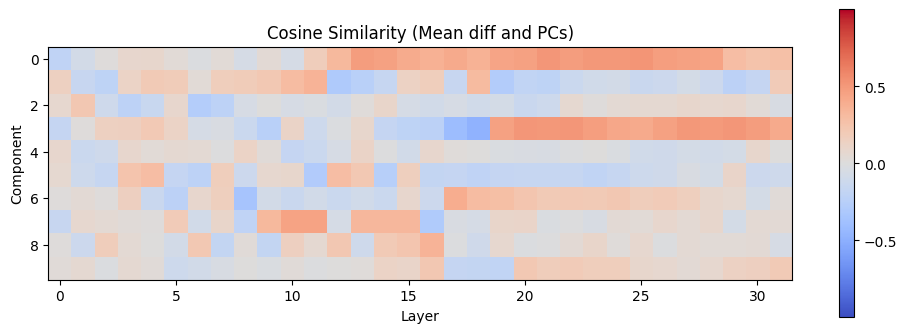

Using layer index: 21
tensor([-0.0056, -0.0046, -0.0072,  ...,  0.0117,  0.0147,  0.0098])


103099

In [10]:
%cd /kaggle/working

import torch
import math
import os
import gc
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

local_repo_dir = "/kaggle/working"
instructions = 128 #32
n_components = 10
n_layers = 32

# Load tensors
harmful_tensors = [torch.load(f"{local_repo_dir}/harmful_states/{i}.pt", weights_only=True) for i in range(instructions)]
harmless_tensors = [torch.load(f"{local_repo_dir}/harmless_states/{i}.pt", weights_only=True) for i in range(instructions)]

# Create data
harmful_data = torch.stack(harmful_tensors)
harmless_data = torch.stack(harmless_tensors)

# Standardize data
harmful_data_std = (harmful_data - harmful_data.mean(dim=(0, 1))) / harmful_data.std(dim=(0, 1))
harmless_data_std = (harmless_data - harmless_data.mean(dim=(0, 1))) / harmless_data.std(dim=(0, 1))

harmful_tensors = None
harmless_tensors = None
gc.collect()

pca_components = []
differences = []
variances = []
biases = []
gaps = []

# We can create a majority region of our PCAs by removing the outliers via z-score thresholding
# Once the two regions (harmful and harmless PCA 1st component) are separated we know refusal has been introduced
# The amount of separation that we deem to be "enough" can be controlled by our coverage hyper-parameter
# Calculate our z-score threshold based on coverage
coverage = 0.75
# Inverse CDF on normal distribution with probability equal to our coverage, both tail ends will be trimmed so icdf is used accordingly
z_score_threshold = torch.distributions.normal.Normal(loc=0, scale=1).icdf(torch.tensor([coverage + (1 - coverage) / 2])).item()
print(f"Using z-score threshold: {z_score_threshold}")

# Plot
plots_per_layer = 2
nrows = math.ceil(n_layers / 10)
fig, ax = plt.subplots(nrows=nrows, ncols=10, figsize=(5 * 10 // 2, 4 * nrows // 2))
harmful_sort = []
harmless_sort = []
for i in range(n_layers):
    # PCA index used (should be 0 for the 1st)
    pca_index = 0
    
    # PCA
    pca = PCA(n_components=n_components)
    harmful_pca = torch.tensor(pca.fit_transform(harmful_data[:, i, :]))
    harmless_pca = torch.tensor(pca.transform(harmless_data[:, i, :]))
    pca_components.append(torch.tensor(pca.components_))
    
    # Sort sample instructions for cleaner starting visual
    if i == 0:
        harmful_sort = torch.argsort(harmful_pca[:, pca_index], descending=False)
        harmless_sort = torch.argsort(harmless_pca[:, pca_index], descending=False)
    harmful_pca = harmful_pca[harmful_sort]
    harmless_pca = harmless_pca[harmless_sort]
    
    # Find max and min excluding outliers using Z-score
    # Coverage is a normalized percentage of included elements based on a normal distribution, 99.73% (0.9973) would be a z_score of 3
    def majority_bounds(tensor, pca_index, z_score_threshold=z_score_threshold):
        z_scores = (tensor - tensor.mean()) / tensor.std()
        filtered_indices = torch.where(torch.abs(z_scores) < z_score_threshold)[0]
        filtered = torch.index_select(tensor, 0, filtered_indices)
        return (filtered.min(), filtered.max())
    harmful_min, harmful_max = majority_bounds(harmful_pca[:, pca_index], 0)
    harmless_min, harmless_max = majority_bounds(harmless_pca[:, pca_index], 0)
    
    # Plot
    row = int(i / 10)
    col = i % 10
    y_height = harmful_pca.shape[0]
    y_range = range(y_height)
    ax[row, col].add_patch(plt.Rectangle((harmful_min, 0), harmful_max - harmful_min, y_height, color='red', alpha=0.5))
    ax[row, col].add_patch(plt.Rectangle((harmless_min, 0), harmless_max - harmless_min, y_height, color='blue', alpha=0.5))
    if harmless_min > harmful_max:
        ax[row, col].add_patch(plt.Rectangle((harmful_max, 0), harmless_min - harmful_max, y_height, color=(0, 1, 0), alpha=1.0))
        gaps.append(harmless_min - harmful_max)
    elif harmful_min > harmless_max:
        ax[row, col].add_patch(plt.Rectangle((harmless_max, 0), harmful_min - harmless_max, y_height, color=(0, 1, 0), alpha=1.0))
        gaps.append(harmful_min - harmless_max)
    else:
        gaps.append(0)
    ax[row, col].scatter(harmful_pca[:, pca_index], y_range, color='red', s=8, label='Harmful')
    ax[row, col].scatter(harmless_pca[:, pca_index], y_range, color='blue', s=8, label='Harmless')
    
# Remove un-used plot cells
for i in range(n_layers, nrows * 10):
    row = int(i / 10)
    col = i % 10
    ax[row, col].set_title("")
    ax[row, col].axis("off")
    
# Iterate through our layers until we detect separation between harmful and harmless
layer_index = -1
for i in range(n_layers):
    row = int(i / 10)
    col = i % 10
    if gaps[i] > 0 and layer_index < 0:
        ax[row, col].set_facecolor((0, 1, 0))
        layer_index = i
        ax[row, col].set_title(f"Layer {i} (target)")
    else:
        ax[row, col].set_facecolor((0, 0, 0))
        ax[row, col].set_title(f"Layer {i}")
    
    
plt.tight_layout()
plt.show()

# Convert PCA components to PyTorch tensor
pca_components = torch.stack(pca_components, dim=1)

# Instructions mean
harmful_mean = harmful_data.mean(dim=0)
harmless_mean = harmless_data.mean(dim=0)
mean_diff = harmful_mean - harmless_mean

# Calculate cosine similarity using PyTorch
cosine_similarities = -torch.cosine_similarity(mean_diff.unsqueeze(0), pca_components, dim=2)

# Visualize cosine similarities
plt.figure(figsize=(12, 4))
plt.imshow(cosine_similarities, cmap='coolwarm', interpolation='nearest', vmin=-1.0, vmax=1.0)
cbar = plt.colorbar()
cbar.set_ticks([-0.5, 0.0, 0.5])
plt.xlabel('Layer')
plt.ylabel('Component')
plt.title('Cosine Similarity (Mean diff and PCs)')
plt.show()

# Ideal layer index
if layer_index == -1:
    layer_index = n_layers // 2
print(f"Using layer index: {layer_index}")

# Save ideal layer mean_diff as refusal direction
mean_diff = mean_diff[layer_index]
refusal_direction = mean_diff / mean_diff.norm()
print(refusal_direction)
local_repo_dir = "/kaggle/working/aya-expanse-8b"
if not os.path.exists(local_repo_dir):
    os.makedirs(local_repo_dir)
torch.save(refusal_direction, local_repo_dir + "/" + "refusal_direction.pt")

# Clean-up
cosine_similarities = None
pca_components = None
differences = None
variances = None
scores = None
harmful_data = None
harmless_data = None
harmful_mean = None
harmless_mean = None
mean_diff = None
gc.collect()


# Optional: Remove temporary harmful and harmless hidden state files

In [ ]:
%cd /kaggle/working
!rm -r ./harmful_states
!rm -r ./harmless_states

# Download/modify/upload individual safetensors files separately to save memory

To save space in kaggle, I will download each split separately and patch it, then upload it to my own repo.

All of the smaller files will be uploaded as a folder.

Be sure to change the repo to your newly created huggingface repo and set all your kaggle secrets for reading and writing to hf!

There is some basic code to check and resume progress if something fails during the process. Not perfect, but helpful.

In [ ]:
%cd /kaggle/working

import os
import gc
gc.collect()

from safetensors import safe_open
from safetensors.torch import save_file
from typing import Optional, Tuple

import einops
import jaxtyping
import torch

from huggingface_hub import hf_hub_download
from huggingface_hub import upload_folder
from huggingface_hub import upload_file

from transformers import AutoConfig

local_repo_dir = "/kaggle/working/aya-expanse-8b"

repo_id = "lenML/aya-expanse-8b-abliterated"

temp_dir = "/kaggle/temp"

from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
read_token = user_secrets.get_secret("hf_read")
write_token = user_secrets.get_secret("hf_write")

# Download necessary files
try:
    for filename in ["config.json", 
                     "generation_config.json",
                     "model.safetensors.index.json", 
                     "special_tokens_map.json", 
                     "tokenizer.json", 
                     "tokenizer.model", 
                     "tokenizer_config.json"]:
        hf_hub_download(repo_id="adamo1139/aya-expanse-8b-ungated", filename=filename, local_dir=local_repo_dir, use_auth_token=read_token)
except Exception as e:
    print(f"Error downloading {filename}: {e}")

# Upload smaller files first
try:
    upload_folder(folder_path=local_repo_dir, repo_id=repo_id, token=write_token)
except Exception as e:
    print(f"Error uploading folder: {e}")

# Load model config and refusal direction
config = AutoConfig.from_pretrained(local_repo_dir, local_files_only=True, trust_remote_code=True)
refusal_direction = torch.load(local_repo_dir + "/" + "refusal_direction.pt").to(torch.float32)

def orthogonalize_matrix(matrix: jaxtyping.Float[torch.Tensor, "... d"], 
                        direction: jaxtyping.Float[torch.Tensor, "d"]) -> jaxtyping.Float[torch.Tensor, "... d"]:
    proj = einops.einsum(matrix, direction.view(-1, 1), "... d, d single -> ... single") * direction
    return matrix - proj

def load_safetensors_file(file_path):
    """Loads a single safetensors file into a dictionary of tensors.
    Args:
        file_path (str): Path to the safetensors file.
    Returns:
        dict: A dictionary containing the loaded tensors.
    """
    tensors = {}
    with safe_open(file_path, framework="pt", device="cpu") as f:
        #print(f.metadata())
        for key in f.keys():
            tensors[key] = f.get_tensor(key)
    return tensors

# Make sure safetensors count matches the actual count for the model you are modifying
safetensors_count = 4

# Check for upload progress, if none create one
progress = None
progress_filename = "/kaggle/working/upload_progress.pt"
if os.path.isfile(progress_filename):
    progress = torch.load(progress_filename, weights_only=True)
else:
    progress = torch.tensor([0, 0])
    torch.save(progress, progress_filename)

start_index = progress[0]
device = refusal_direction.device
# TODO: Add in skip start and end layers logic
#       I forgot to in v1.0 but the abliterated output model still worked great so I didn't even notice
for idx in range(start_index, safetensors_count):
    gc.collect()
    
    # Check if we have already processed 
    
    # Current .safetensors
    filename = "model-" + str(idx + 1).zfill(5) + "-of-" + str(safetensors_count).zfill(5) + ".safetensors"
    print(filename)
    
    # Local file path
    file_path = temp_dir + "/" + filename
    
    # Check if we need to skip processing this file and just upload it
    skip_processing = False
    
    # Download file 
    if os.path.isfile(file_path):
        skip_processing = True if progress[1] >= 1 else False
    else:
        hf_hub_download(repo_id="adamo1139/aya-expanse-8b-ungated", filename=filename, local_dir=temp_dir, use_auth_token=read_token)
    
    if not skip_processing:
        # Load local file
        tensors = load_safetensors_file(file_path)

        for tensor in tensors:
            # tok_embeddings
            if ".embed_tokens.weight" in tensor:
                print("• " + tensor)
                dtype = tensors[tensor].dtype
                t = tensors[tensor].to(torch.float32).to(device)
                tensors[tensor].copy_(orthogonalize_matrix(t, refusal_direction).to(dtype))
                t = []

            # attention.wo
            if ".self_attn.o_proj.weight" in tensor:
                print("• " + tensor)
                dtype = tensors[tensor].dtype
                t = tensors[tensor].to(torch.float32).to(device)
                t_rearranged = einops.rearrange(t, "m (n h) -> n h m", n=config.num_attention_heads).to(device)
                t_orthogonalized = orthogonalize_matrix(t_rearranged, refusal_direction)
                t_rearranged = einops.rearrange(t_orthogonalized, "n h m -> m (n h)", n=config.num_attention_heads)
                tensors[tensor].copy_(t_rearranged.to(dtype))
                t = []
                t_rearranged = []
                t_orthogonalized = []

            # feed_forward.w2
            if ".mlp.down_proj.weight" in tensor:
                print("• " + tensor)
                dtype = tensors[tensor].dtype
                t = tensors[tensor].to(torch.float32).to(device)
                t_transposed = t.T.to(device)
                t_orthogonalized = orthogonalize_matrix(t_transposed, refusal_direction)
                t_transposed = t_orthogonalized.T
                tensors[tensor].copy_(t_transposed.to(dtype))
                t = []
                t_transposed = []
                t_orthogonalized = []

        # Save file
        save_file(tensors, file_path, metadata={'format': 'pt'})

        # Save progress after processing
        progress[1] = 1
        torch.save(progress, progress_filename)
        
    # Upload file if we need to
    skip_upload = True if progress[1] >= 2 else False
    if not skip_upload:
        # Upload file to your repo
        upload_file(path_or_fileobj=file_path, path_in_repo=filename, repo_id=repo_id, token=write_token)
        
        # Save progress after processing
        progress[1] = 2
        torch.save(progress, progress_filename)

    # Try to remove file if it still exists
    import os
    if os.path.exists(file_path):
        os.remove(file_path)
    else:
        print("Remove error: The file does not exist")
        
    # Save progress for next file
    progress[0] = idx + 1
    progress[1] = 0
    torch.save(progress, progress_filename)

# Delete progress file
!rm /kaggle/working/upload_progress.pt

# Patching done
print("Done!")


# Use GGUF My Repo space on HF to convert abliterated model back to GGUF

# Test in your favorite llama.cpp or GGUF environment